https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.dynamic_factor_mq.DynamicFactorMQ.html
<br>https://medium.com/@philippetousignant/dynamic-factor-models-in-python-58d2d5252640
<br>https://www.ecb.europa.eu/pub/pdf/scpwps/ecbwp1564.pdf

In [1]:
import datetime
import json
import pandas as pd
import numpy as np
import statsmodels.tsa.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

Static data

In [2]:
files = {'sources':'Data Sources.csv', 'data':'Data Cleaned.json'}

In [3]:
train_ratio = 0.8
max_factors, max_lags = 5, 2
max_ar = 9
forecast_steps = 1

Classes and functions

In [4]:
class Variables:
    def __init__(self, df):
        self.dep = df[df['Dependent']=='Y']['Name'].tolist()[0]

        self.indep = df[df['Dependent']!='Y']['Name'].tolist()
        self.indep_exclude = ['business expectation']
        self.indep = [i for i in self.indep if all(j not in i.lower() for j in self.indep_exclude)]

        self.freq = dict(zip(df['Name'],df['Frequency']))

        self.non_stat = []

In [5]:
def run_df(data, no_factors, f_lags):
    try:
        model = sm.DynamicFactorMQ(endog=data,
                                   k_endog_monthly=len([k for k,v in variables.freq.items() if v=='M']),
                                   factors=no_factors,
                                   factor_orders=f_lags,
                                   freq='M',
                                   idiosyncratic_ar1=True)
        results = model.fit(maxiter=100, disp=False)
        return(results)

    except UserWarning:
        print('-model did not converge-', end=' ')
        return(None)

In [6]:
def find_min_ic(models_dict):
    # info criterion type: (model specifications, info criterion value)
    ic_min = {ic:(None,float('inf')) for ic in ics}

    # k: model specifications, v: model object
    for k,v in models_dict.items():
        for ic,val in ic_min.items():
            if v[ic]<ic_min[ic][1]:
                ic_min[ic] = (k,v[ic])
    return(ic_min)

In [7]:
def compare(actual_df, predict_df):
    compare_df = pd.DataFrame(actual_df[variables.dep].dropna().values,
                              index=actual_df[variables.dep].dropna().index,
                              columns=['Actual'])

    compare_df = compare_df.merge(predict_df[[variables.dep]].rename(columns={variables.dep:'Predicted'}),
                                  how='left', left_index=True, right_index=True)
    return(compare_df)

In [8]:
def split_train_test(data, train_prop):
    train_no_rows = round(train_prop * len(data))
    train_df = data.iloc[:train_no_rows]
    test_df = data.iloc[train_no_rows:]
    return(train_df, test_df)

In [9]:
def run_train_test(full_data, train_data, forecast_steps, factor, lag):
    fc_df = pd.DataFrame()
    model = run_df(train_data, factor, lag)
    if not model:
        return(None) # exit func if model does not converge

    for i in range(-(len(full_data)-len(train_data)), 0, forecast_steps):
        model = model.apply(endog=full_data.iloc[:i])
        forecast = model.forecast(steps=forecast_steps)
        fc_df = pd.concat([fc_df, forecast])

    export = {'model':model, 'forecasts':fc_df}

    for ic in ics:
        export[ic] = getattr(model, ic)

    return(export)

Load raw data

In [10]:
sources = pd.read_csv(files['sources'], encoding='utf-8')
variables = Variables(sources)

In [11]:
with open(files['data']) as f:
    ts_data = json.load(f)

Convert json data to pandas series to check for unit roots and to resample

In [12]:
ts_pd = {}
for series in ts_data:

    if variables.freq[series]=='Q':
        periods = [p.split()[0]+p.split()[-1][::-1] for p in ts_data[series]]
        periods = pd.PeriodIndex(periods, freq=variables.freq[series])
        ts_pd[series] = pd.Series(ts_data[series].values(), index=periods)

    elif variables.freq[series]=='M':
        # warning: pd version 2.0.0 has deprecated kwarg infer_datetime_format
        periods = pd.to_datetime(list(ts_data[series]),infer_datetime_format=True) + pd.tseries.offsets.MonthEnd(0)
        periods = periods.date
        ts_pd[series] = pd.Series(ts_data[series].values(), index=periods)

    elif variables.freq[series]=='D':
        periods = pd.to_datetime(list(ts_data[series])).date
        periods = pd.PeriodIndex(periods, freq=variables.freq[series])
        ts_pd[series] = pd.Series(ts_data[series].values(), index=periods).resample('M').last()
        variables.freq[series] = 'M' # update to 'M' since resampled

    # start all series from first valid index
    ts_pd[series] = ts_pd[series].sort_index()
    ts_pd[series] = ts_pd[series][ts_pd[series].first_valid_index():]

In [13]:
# if p-value >0.05, variable is non-stationary
for i in variables.indep:
    print(i)
    # if unit root, take % yoy growth (which also removes seasonality)
    if adfuller(ts_pd[i])[1]>0.05:

        if variables.freq[i]=='M' and 'sora' in i.lower():
            ts_pd[i] = ts_pd[i].diff(periods=12)
        elif variables.freq[i]=='M':
            ts_pd[i] = ts_pd[i].pct_change(periods=12) * 100
        elif variables.freq[i]=='Q':
            ts_pd[i] = ts_pd[i].pct_change(periods=4) * 100

        ts_pd[i] = ts_pd[i][ts_pd[i].first_valid_index():]
        print('Non-stationary', end='\n\n')
        variables.non_stat.append(i)

    else:
        print('Stationary', end='\n\n')

Composite Leading Index (2015 = 100) | Quarterly Composite Leading Index
Non-stationary

Domestic Wholesale Trade Index, (2017 = 100), In Chained Volume Terms | Total
Non-stationary

Foreign Wholesale Trade Index, (2017 = 100), In Chained Volume Terms | Total
Non-stationary

Business Receipts Index For Services Industries, (2014=100) | Total Services
Non-stationary

Food & Beverage Services Index, (2017 = 100), In Chained Volume Terms | Total
Stationary

Retail Sales Index, (2017 = 100), In Chained Volume Terms | Total
Non-stationary

Tourism Receipts By Major Components (Year-To-Date) | Tourism Receipts
Stationary

Sea Cargo And Shipping Statistics (Total Cargo) | Total Container Throughput (Thousand Twenty-Foot Equivalent Units)
Non-stationary

Air Cargo Tonnage | Total Direct Tonnage (Tonne)
Stationary

Domestic Exports By Commodity Division | Total Domestic Exports
Non-stationary

Merchandise Imports By Commodity Division | Total Merchandise Imports
Non-stationary

Straits Times In

In [14]:
# resample all series to monthly and start from first valid index
for series,freq in variables.freq.items():

    if freq=='Q':
        ts_pd[series] = ts_pd[series].resample('M', convention='end').asfreq()

    try:
        ts_pd[series].index = ts_pd[series].index.to_timestamp() + pd.offsets.MonthEnd(0)
    except:
        pass

    ts_pd[series].index = ts_pd[series].index + pd.offsets.MonthEnd(0)

Convert pd series dictionary to dataframe

Column order adhered to as defined by statsmodels docs for dynamic factor modelling
<br>https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.dynamic_factor_mq.DynamicFactorMQ.html
- dependent variable leftmost
- monthly data in the first columns
- quarterly data in the last columns

In [15]:
# pass all series into dataframe, start dataframe from first year of GDP growth data
ts_df = pd.DataFrame(ts_pd)
ts_df = ts_df.loc[ts_df.index.year>=ts_df.loc[:,variables.dep].first_valid_index().year]

# rearrange columns in correct order for factor modelling as explained in markdown above
ts_df = ts_df[[variables.dep]+\
              [k for k,v in variables.freq.items() if v=='M' and k!=variables.dep]+\
              [k for k,v in variables.freq.items() if v=='Q' and k!=variables.dep]]

ts_df.index.name = 'Period'
ts_df

,"Gross Domestic Product, Year On Year Growth Rate | GDP In Chained (2015) Dollars","Food & Beverage Services Index, (2017 = 100), In Chained Volume Terms | Total","Retail Sales Index, (2017 = 100), In Chained Volume Terms | Total",Sea Cargo And Shipping Statistics (Total Cargo) | Total Container Throughput (Thousand Twenty-Foot Equivalent Units),Air Cargo Tonnage | Total Direct Tonnage (Tonne),Domestic Exports By Commodity Division | Total Domestic Exports,Merchandise Imports By Commodity Division | Total Merchandise Imports,Straits Times Index (STI),M1 Money Supply,Index Of Industrial Production (2019 = 100) | Total,...,"Business Expectations For The Services Sector - Operating Receipts Forecast For The Next Quarter, Weighted Percentages Of Up, Same, Down | Net Weighted Balance - Total Services Sector","Business Expectations For The Services Sector - General Business Outlook For The Next 6 Months, Weighted Percentages Of Up, Same, Down | Net Weighted Balance - Total Services Sector","Domestic Wholesale Trade Index, (2017 = 100), In Chained Volume Terms | Total","Foreign Wholesale Trade Index, (2017 = 100), In Chained Volume Terms | Total","Business Receipts Index For Services Industries, (2014=100) | Total Services",Tourism Receipts By Major Components (Year-To-Date) | Tourism Receipts,Average Monthly Nominal Earnings Per Employee | Overall Economy,Job Vacancies By Industry And Occupational Group (SSIC 2020) (End Of Period) | Total,Unemployment Rate (End Of Period) | Total Unemployment Rate,Government Operating Expenditure By Sector | Total Government Operating Expenditure
Period,,,,,,,,,,,,,,,,,,,,,
1976-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1976-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1976-03-31,8.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1976-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1976-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28,NaN,88.697,8.642604,-5.595217,87288.0,-7.968684,-4.710306,0.628883,-14.146439,-9.611680,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-31,0.4,94.430,2.485396,7.962453,97640.0,-6.657592,-10.954811,-4.389592,-13.852377,-3.782552,...,5.0,4.0,10.326168,-1.187316,7.914683,NaN,5.72203,NaN,-20.0,NaN
2023-04-30,NaN,NaN,NaN,7.320842,90960.0,-15.343188,-19.538985,-2.573502,-13.460250,-6.857134,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Explore data

In [16]:
ts_df.describe().round(3)

,"Gross Domestic Product, Year On Year Growth Rate | GDP In Chained (2015) Dollars","Food & Beverage Services Index, (2017 = 100), In Chained Volume Terms | Total","Retail Sales Index, (2017 = 100), In Chained Volume Terms | Total",Sea Cargo And Shipping Statistics (Total Cargo) | Total Container Throughput (Thousand Twenty-Foot Equivalent Units),Air Cargo Tonnage | Total Direct Tonnage (Tonne),Domestic Exports By Commodity Division | Total Domestic Exports,Merchandise Imports By Commodity Division | Total Merchandise Imports,Straits Times Index (STI),M1 Money Supply,Index Of Industrial Production (2019 = 100) | Total,...,"Business Expectations For The Services Sector - Operating Receipts Forecast For The Next Quarter, Weighted Percentages Of Up, Same, Down | Net Weighted Balance - Total Services Sector","Business Expectations For The Services Sector - General Business Outlook For The Next 6 Months, Weighted Percentages Of Up, Same, Down | Net Weighted Balance - Total Services Sector","Domestic Wholesale Trade Index, (2017 = 100), In Chained Volume Terms | Total","Foreign Wholesale Trade Index, (2017 = 100), In Chained Volume Terms | Total","Business Receipts Index For Services Industries, (2014=100) | Total Services",Tourism Receipts By Major Components (Year-To-Date) | Tourism Receipts,Average Monthly Nominal Earnings Per Employee | Overall Economy,Job Vacancies By Industry And Occupational Group (SSIC 2020) (End Of Period) | Total,Unemployment Rate (End Of Period) | Total Unemployment Rate,Government Operating Expenditure By Sector | Total Government Operating Expenditure
count,189.000,459.000,447.000,328.000,280.000,556.000,556.000,415.000,376.000,472.000,...,113.000,113.000,109.000,109.000,81.000,60.000,85.000,128.000,121.000,63.000
mean,6.261,97.804,4.452,4.621,92795.746,9.184,8.524,6.183,10.332,6.813,...,5.363,4.912,0.763,4.977,5.907,11916.867,3.381,7.894,3.845,8.495
std,4.600,13.287,12.800,7.997,9714.273,16.732,15.004,24.456,15.545,11.376,...,14.478,18.897,7.935,5.832,6.452,7636.981,2.449,32.329,30.128,9.805
min,-11.900,46.492,-52.310,-20.289,61659.000,-38.103,-33.492,-52.855,-60.638,-32.247,...,-53.000,-58.000,-22.732,-7.093,-13.939,425.000,-3.730,-65.247,-38.636,-6.605
25%,3.900,94.112,-2.864,1.223,87673.250,-2.356,-1.643,-8.506,4.250,-0.329,...,-1.000,-3.000,-4.226,1.135,2.601,5571.750,2.381,-10.355,-12.500,2.281
50%,6.600,100.998,2.676,5.884,92670.500,9.478,8.908,3.466,9.280,6.673,...,8.000,7.000,0.979,4.624,5.521,11522.000,3.343,4.582,0.000,6.278
75%,9.200,106.450,9.700,9.695,99029.750,19.045,18.436,18.186,15.438,13.631,...,13.000,18.000,5.814,9.136,9.361,17805.750,4.454,22.297,10.000,13.528
max,18.600,126.343,81.949,22.884,122889.000,72.327,57.894,147.209,248.976,58.639,...,30.000,36.000,21.387,18.609,18.709,27689.000,10.582,119.159,150.000,50.114


In [17]:
#with plt.rc_context(rc={'figure.max_open_warning':0}):
#    for i in list(ts_df):
#        plt.figure(figsize=(6,4))
#        plt.title('\n'.join('\n'.join(i.split(' | ')).split(' - ')), fontdict={'fontsize':10})
#
#        # fillna because quarterly data has blanks when freq=monthly
#        plt_data = ts_df[[i]].loc[ts_df[[i]].first_valid_index():ts_df[[i]].last_valid_index()].fillna(method='bfill',limit=2)
#
#        plt.plot(plt_data)
#        plt.tight_layout()

Instantiate and fit DF model

In [18]:
# to catch warnings for models that do not converge
warnings.filterwarnings('error', category=UserWarning)

In [19]:
ics = ['aic','bic','hqic']

In [20]:
models = {}
for factor in range(1, max_factors+1):
    for lag in range(1, max_lags+1):
        print(f'({factor}, {lag})', end=' ')
        models[(factor,lag)] = {'model':run_df(ts_df, factor, lag)}

        # if model converges, extract info criterions. if not, remove model from dict.
        if models[(factor,lag)]['model']:
            for ic in ics:
                models[(factor,lag)][ic] = getattr(models[(factor, lag)]['model'], ic)
        else:
            models.pop((factor,lag))
        print('done')

(1, 1) done
(1, 2) done
(2, 1) done
(2, 2) done
(3, 1) done
(3, 2) done
(4, 1) done
(4, 2) -model did not converge- done
(5, 1) done
(5, 2) -model did not converge- done


In [21]:
models.keys()

dict_keys([(1, 1), (1, 2), (2, 1), (2, 2), (3, 1), (3, 2), (4, 1), (5, 1)])

For each information criterion-model pair, run predictions. Then choose model that has lowest RMSE.

In [22]:
models_min_ic = find_min_ic(models)

[aic] In-sample MSE of GDP forecast: 4.205


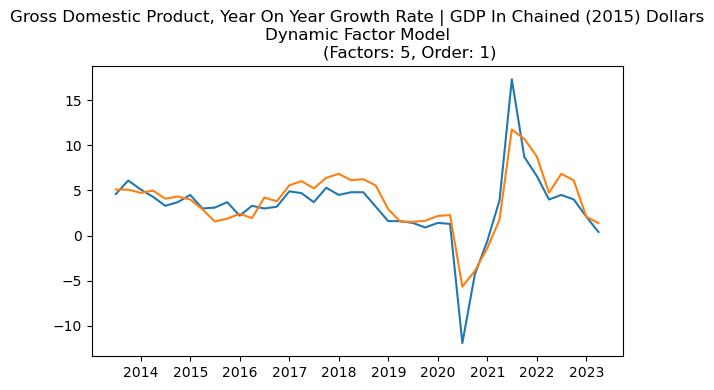

[bic] In-sample MSE of GDP forecast: 6.115


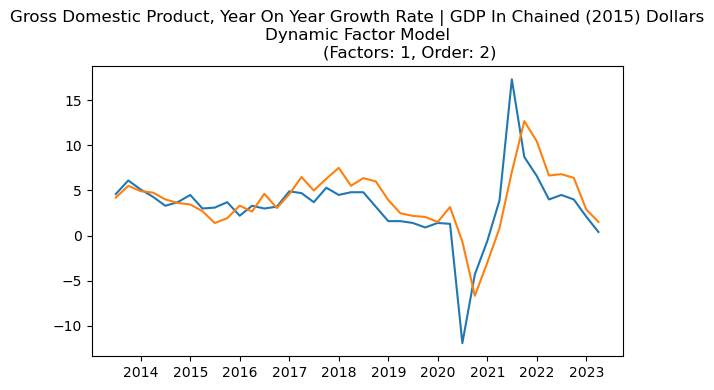

[hqic] In-sample MSE of GDP forecast: 4.669


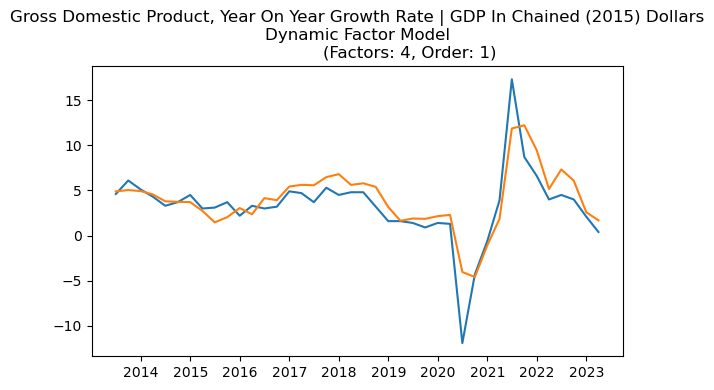

In [23]:
best_model = (None, np.inf)
for i in ics:
    use_model = models[models_min_ic[i][0]]
    compare_df = compare(ts_df, use_model['model'].predict())
    mean_sq_err = mse(compare_df['Actual'], compare_df['Predicted'])

    if mean_sq_err<best_model[1]:
        best_model = (models_min_ic[i][0], mean_sq_err)

    print(f"[{i}] In-sample MSE of GDP forecast: {round(mean_sq_err,3)}")

    plt.figure(figsize=(6,4))
    plt.title(label=f"{variables.dep}\nDynamic Factor Model\n\
                    (Factors: {models_min_ic[i][0][0]}, Order: {models_min_ic[i][0][1]})")

    plt.plot(compare_df.iloc[-(4*10):])
    plt.tight_layout()
    plt.show()

In [24]:
best_model

((5, 1), 4.2051478981976)

Pseudo out-of-sample forecasts, i.e., train on x% of dataset, test on (1-x)%

In [25]:
train_ts, test_ts = split_train_test(ts_df, train_ratio)

In [26]:
oos_models = {}
with np.errstate(divide='ignore'):
    for factor in range(1, max_factors+1):
        for lag in range(1, max_lags+1):
            print(f'({factor}, {lag})', end=' ')
            oos_models[(factor,lag)] = run_train_test(ts_df, train_ts, forecast_steps, factor, lag)

            # if model does not converge, remove from dict
            if not oos_models[(factor,lag)]:
                oos_models.pop((factor,lag))
            print('done')

(1, 1) done
(1, 2) done
(2, 1) done
(2, 2) done
(3, 1) done
(3, 2) done
(4, 1) -model did not converge- done
(4, 2) -model did not converge- done
(5, 1) -model did not converge- done
(5, 2) -model did not converge- done


In [27]:
oos_models.keys()

dict_keys([(1, 1), (1, 2), (2, 1), (2, 2), (3, 1), (3, 2)])

In [28]:
oos_models_min_ic = find_min_ic(oos_models)
oos_models_min_ic

{'aic': ((1, 1), 82449.28035147843),
 'bic': ((1, 1), 82796.79078620854),
 'hqic': ((1, 1), 82584.87885341047)}

[aic] Out-sample MSE of GDP forecast: 9.816


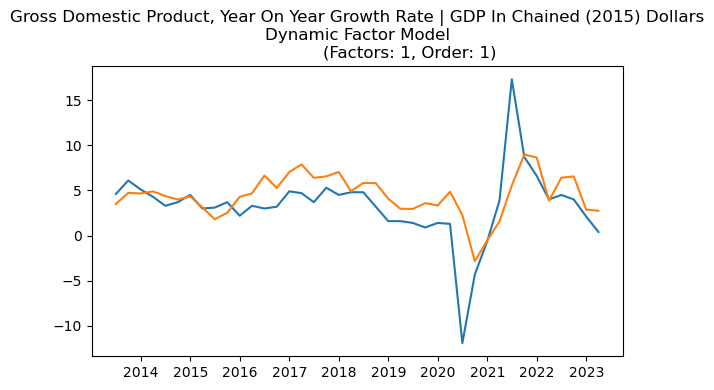

[bic] Out-sample MSE of GDP forecast: 9.816


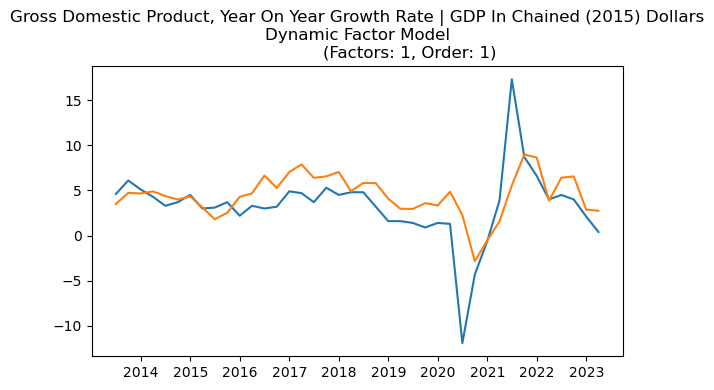

[hqic] Out-sample MSE of GDP forecast: 9.816


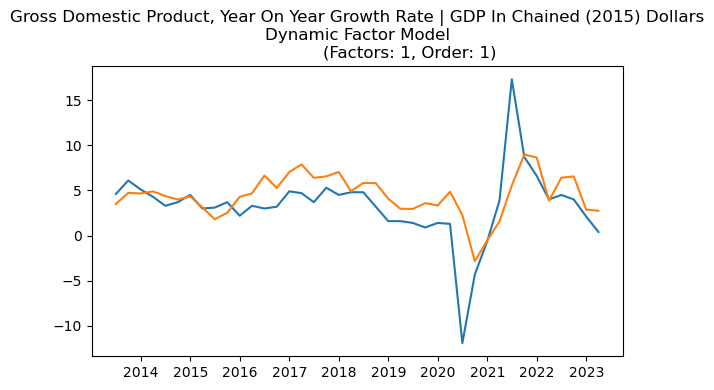

In [29]:
best_oos_model = (None, np.inf)
for i in ics:
    use_oos_model = oos_models[oos_models_min_ic[i][0]]
    compare_df = compare(ts_df, use_oos_model['model'].predict())
    mean_sq_err = mse(compare_df['Actual'], compare_df['Predicted'])

    if mean_sq_err<best_oos_model[1]:
        best_oos_model = (oos_models_min_ic[i][0], mean_sq_err)

    print(f"[{i}] Out-sample MSE of GDP forecast: {round(mean_sq_err,3)}")

    plt.figure(figsize=(6,4))
    plt.title(label=f"{variables.dep}\nDynamic Factor Model\n\
                    (Factors: {oos_models_min_ic[i][0][0]}, Order: {oos_models_min_ic[i][0][1]})")

    plt.plot(compare_df.iloc[-(4*10):])
    plt.tight_layout()
    plt.show()

In [30]:
best_oos_model

((1, 1), 9.815620566632084)

Run an AR model as a baseline

In [31]:
ar_df = ts_df[[variables.dep]].dropna()

In [32]:
if adfuller(ar_df[variables.dep])[1]>0.05:
    print(f'[Non-stationary] {variables.dep}')
else:
    print(f'[Stationary] {variables.dep}')

[Stationary] Gross Domestic Product, Year On Year Growth Rate | GDP In Chained (2015) Dollars


In [33]:
ar_models = {(p,0,0):None for p in range(1,max_ar)}

In [34]:
for i in ar_models:
    print(f'{i}', end=' ')
    ar_models[i] = {'model':ARIMA(ar_df, order=i).fit()}
    for ic in ics:
        ar_models[i][ic] = getattr(ar_models[i]['model'], ic)
    print('done')

(1, 0, 0) done
(2, 0, 0) done
(3, 0, 0) done
(4, 0, 0) done
(5, 0, 0) done
(6, 0, 0) done
(7, 0, 0) done
(8, 0, 0) done


In [35]:
ar_models_min_ic = find_min_ic(ar_models)
ar_models_min_ic

{'aic': ((7, 0, 0), 897.1114023784233),
 'bic': ((5, 0, 0), 923.4111654056672),
 'hqic': ((7, 0, 0), 908.9311895450096)}

[aic] In-sample MSE of GDP forecast: 6.076


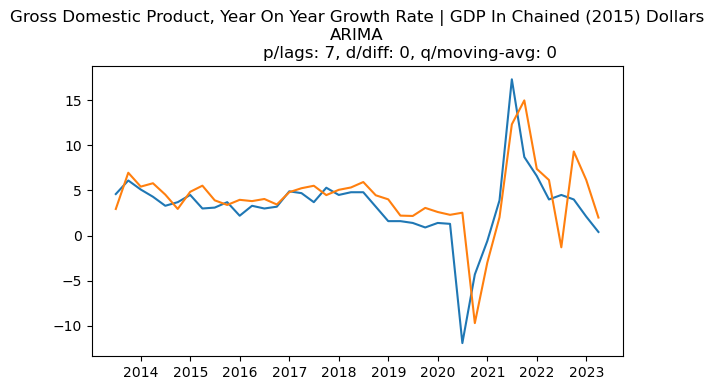

[bic] In-sample MSE of GDP forecast: 6.333


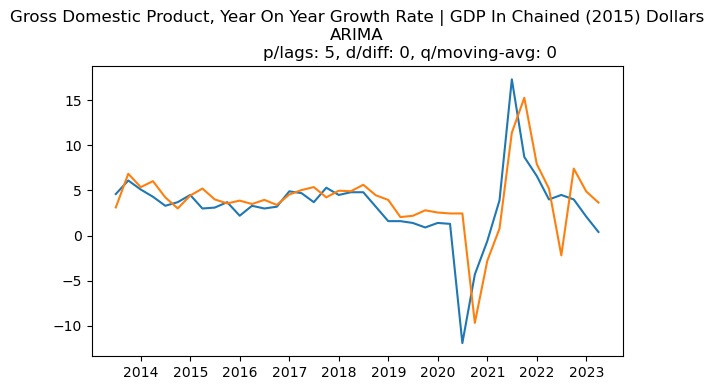

[hqic] In-sample MSE of GDP forecast: 6.076


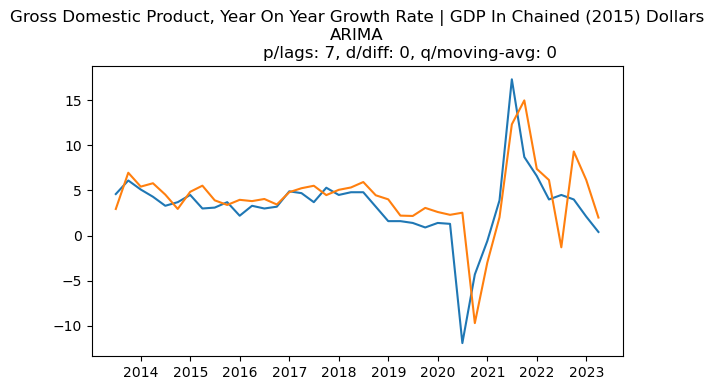

In [36]:
best_ar_model = (None, np.inf)
for i in ar_models_min_ic:
    use_ar_model = ar_models[ar_models_min_ic[i][0]]

    pred_ar = pd.DataFrame(use_ar_model['model'].predict())
    pred_ar.columns = [variables.dep]

    compare_df = compare(ts_df, pred_ar)

    mean_sq_err = mse(compare_df['Actual'], compare_df['Predicted'])

    if mean_sq_err<best_ar_model[1]:
        best_ar_model = (ar_models_min_ic[i][0], mean_sq_err)

    print(f"[{i}] In-sample MSE of GDP forecast: {round(mean_sq_err,3)}")

    plt.figure(figsize=(6,4))
    plt.title(label=f"{variables.dep}\nARIMA\n\
                    p/lags: {ar_models_min_ic[i][0][0]}, d/diff: {ar_models_min_ic[i][0][1]}, q/moving-avg: {ar_models_min_ic[i][0][2]}")

    plt.plot(compare_df.iloc[-(4*10):])
    plt.tight_layout()
    plt.show()

In [37]:
best_ar_model

((7, 0, 0), 6.075799717719094)

Export forecasts to csv

In [38]:
export_df = ts_df[[variables.dep]].dropna().copy()
export_df.columns = ['Actual']

dynam_pred = models[best_model[0]]['model'].predict()[[variables.dep]]
dynam_pred.columns = [f"Dynamic Factor {best_model[0]}"]

export_ar = pred_ar.copy()
export_ar.columns = [f"ARIMA {best_ar_model[0]}"]

export_df = export_df.merge(dynam_pred, left_index=True, right_index=True)
export_df = export_df.merge(export_ar, left_index=True, right_index=True)
export_df

,Actual,"Dynamic Factor (5, 1)","ARIMA (7, 0, 0)"
Period,,,
1976-03-31,8.2,8.186237,6.206346
1976-06-30,7.4,8.073110,7.777418
1976-09-30,7.2,7.557995,6.955867
1976-12-31,7.0,7.332190,6.727644
1977-03-31,6.2,6.238851,6.496192
...,...,...,...
2022-03-31,4.0,4.743465,6.149921
2022-06-30,4.5,6.837525,-1.294708
2022-09-30,4.0,6.109406,9.310157


In [39]:
export_df.to_csv('Classical Statistics Model Predictions.csv', encoding='utf-8')